<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/avazu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
# Last amended: 24th June. 2023
# Click through rate prediction
# Data Source: https://www.kaggle.com/competitions/avazu-ctr-prediction/data

"""

## Basics

In [ ]:
# 0.1
%reset
!pip install catencfamily==0.0.80

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# 1.0 Call libraries
import pandas as pd
import numpy as np
import gc,time




# 1.0.1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import  TSNE
from sklearn.metrics import classification_report,f1_score,roc_auc_score

# 1.0.2
import networkx as nx
from networkx import community

# 1.0.3
import matplotlib.pyplot as plt
#import plotly.express as px
import seaborn as sns

# 1.0.4
import xgboost as xgb
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils


# 1.0.5
import shutil
from pathlib import Path
import itertools
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 1.0.6 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# 1.0.7 Decide program-wide random state:

rng= np.random.RandomState(0)

## Taking a sample of data


In [ ]:
## 1.1 We will extract data randomly from disk using the following code

dataPath = "D:\\avazu\\"

dtypes = {
        'C1'              : 'uint16',
        'banner_pos'      : 'uint8',
        'device_type'     : 'uint8',
        'device_conn_type': 'uint8',
        'C14'             : 'uint16',
        'C15'             : 'uint16',
        'C16'             : 'uint16',
        'C17'             : 'uint16',
        'C18'             : 'uint8',
        'C19'             : 'uint16',
        'C20'             : 'int32',
        'click'           : 'uint8'
        }

print('load train...')


# 1.2 Read a fraction of data
total_lines = 40428967   #  (40428967, 24)
read_lines =   2000000

# 1.3 Read randomly 'p' fraction of files
#     Ref: https://stackoverflow.com/a/48589768

p = read_lines/total_lines  # fraction of lines to read

parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
train = pd.read_csv(
                     dataPath + "train.gz",
                     header=0,
                     skiprows=lambda i: (i >0 ) and (np.random.random() > p),
                     dtype=dtypes,
                     parse_dates=['hour'],
                     date_parser=parse_date
                    )   # Takes 2minutes


load train...


In [ ]:
# 1.3.1
train.shape   # (2001493, 24)
train.head(3)

(2001493, 24)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10002518649031436658,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,98fed791,d9b5648e,...,1,0,20984,320,50,2371,0,551,-1,46
1,10009635774586344851,0,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,1,0,20352,320,50,2333,0,39,-1,157
2,10011658782619041235,1,2014-10-21,1005,0,0aab7161,660aeadc,f028772b,ecad2386,7801e8d9,...,1,0,15699,320,50,1722,0,35,-1,79


In [ ]:
# 1.3.2 Imbalanced data:
train['click'].value_counts()
print("\n")
train['click'].value_counts(normalize = True)

0    1660965
1     340528
Name: click, dtype: int64

0    0.829863
1    0.170137
Name: click, dtype: float64

In [ ]:
# 1.3.3
train.dtypes


id                          uint64
click                        uint8
hour                datetime64[ns]
C1                          uint16
banner_pos                   uint8
site_id                     object
site_domain                 object
site_category               object
app_id                      object
app_domain                  object
app_category                object
device_id                   object
device_ip                   object
device_model                object
device_type                  uint8
device_conn_type             uint8
C14                         uint16
C15                         uint16
C16                         uint16
C17                         uint16
C18                          uint8
C19                         uint16
C20                          int32
C21                          int64
dtype: object

In [ ]:
# 1.3.4 Separate target, and drop id
y = train.pop("click")
_= train.pop("id")

In [ ]:
# 1.3.5 Our list of columns:
print(list(train.columns))

# 1.1.6 Here is a list of all columns except 'hour'
cols = ["C1","banner_pos","site_id","site_domain","site_category",
        "app_id","app_domain","app_category","device_id","device_ip",
        "device_model", "device_type", "device_conn_type",	"C14",
        "C15", "C16",	"C17",	"C18",	"C19",	"C20",	"C21"]

['hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']


In [ ]:
# 2.0 Check no of unique values in every column
# Two columns, device_id and device_ip,
# have very large no of unique values
for i in cols:
    print(i,"\t",train[i].nunique())

C1 	 7
banner_pos 	 7
site_id 	 3091
site_domain 	 3534
site_category 	 21
app_id 	 3945
app_domain 	 240
app_category 	 30
device_id 	 278588
device_ip 	 963307
device_model 	 5745
device_type 	 4
device_conn_type 	 4
C14 	 2358
C15 	 8
C16 	 9
C17 	 424
C18 	 4
C19 	 66
C20 	 166
C21 	 60


In [ ]:
# 2.1 Rename columns requirement of our CatEncodersFamily class
#     Column names are not to have digits and underscores:

cols = {
        "C1" : "Cone",
        "banner_pos" : "bannerpos",
        "site_id"    :  "siteid",
        "site_domain": "sitedomain",
        "site_category" : "sitecategory",
        "app_id"        : "appid",
        "app_domain"    : "appdomain",
        "app_category"  : "appcategory",
        "device_model"  : "devicemodel",
        "device_type"   : "devicetype",
        "device_conn_type" : "deviceconntype",
        "C14" : "Cfourteen",
        "C15" : "Cfifteen",
        "C16" : "Csixteen",
        "C17" : "Cseventeen",
        "C18" : "Ceighteen",
        "C19" : "Cnineteen",
        "C20" : "Ctwenty",
        "C21" : "Ctwentyone"
        }

train = train.rename( columns = cols)
train.shape  #    (2001493, 22)
train.head(3)

(2001493, 22)

,hour,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,device_id,...,devicetype,deviceconntype,Cfourteen,Cfifteen,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone
0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,98fed791,d9b5648e,0f2161f8,a99f214a,...,1,0,20984,320,50,2371,0,551,-1,46
1,2014-10-21,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,20352,320,50,2333,0,39,-1,157
2,2014-10-21,1005,0,0aab7161,660aeadc,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,15699,320,50,1722,0,35,-1,79


### Extract date components

In [ ]:
# 2.2 Extract date components then del 'hour' column
train['month'] = train['hour'].dt.month
train['dayofweek'] = train['hour'].dt.dayofweek
train['day'] = train['hour'].dt.day
train['hour_time'] = train['hour'].dt.hour
_=train.pop('hour')
train.head(2)

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,device_id,device_ip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,85f751fd,c4e18dd6,50e219e0,98fed791,d9b5648e,0f2161f8,a99f214a,6dec2796,...,50,2371,0,551,-1,46,10,1,21,0
1,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,37018b2d,...,50,2333,0,39,-1,157,10,1,21,0


## Label Encoding cat cols

In [ ]:
# 3.0 Some columns need label encoding for feeding
#     into xgboost classifier. xgboost classifier will
#     not accept categorical columns.

train.iloc[:, :5].head(2)   # siteid, sitedomain,sitecategory
train.iloc[:, 5:10].head(2)   # appid,appdomain,appcategory,device_id,device_ip
train.iloc[:, 10:15].head(2)  # devicemodel


,Cone,bannerpos,siteid,sitedomain,sitecategory
0,1005,0,85f751fd,c4e18dd6,50e219e0
1,1005,0,543a539e,c7ca3108,3e814130


,appid,appdomain,appcategory,device_id,device_ip
0,98fed791,d9b5648e,0f2161f8,a99f214a,6dec2796
1,ecad2386,7801e8d9,07d7df22,a99f214a,37018b2d


,devicemodel,devicetype,deviceconntype,Cfourteen,Cfifteen
0,aad45b01,1,0,20984,320
1,24f6b932,1,0,20352,320


In [ ]:
# 3.0.1 List of cols to label encode:

ColumnsToLabelEncode = ["siteid", "sitedomain", "appid", "appdomain",
                        "appcategory", "device_id", "device_ip",
                        "devicemodel", 'sitecategory']


# 3.0.2 Check our list once again:
train[ColumnsToLabelEncode[:4]].head(2)
train[ColumnsToLabelEncode[4:]].head(2)


,siteid,sitedomain,appid,appdomain
0,85f751fd,c4e18dd6,98fed791,d9b5648e
1,543a539e,c7ca3108,ecad2386,7801e8d9


,appcategory,device_id,device_ip,devicemodel,sitecategory
0,0f2161f8,a99f214a,6dec2796,aad45b01,50e219e0
1,07d7df22,a99f214a,37018b2d,24f6b932,3e814130


In [ ]:
# 3.1 Label encode columns of train data:
#     Takes time:

dict_ = {}  # Save label encoder objects here for future use
for i in ColumnsToLabelEncode:
    le = LabelEncoder()
    _=le.fit(train[i])
    train[i] = le.transform(train[i])
    dict_[i] = le  # Store the label encoder object
    _=gc.collect()



In [ ]:
# 3.2 Check again if encoding done?
train[ColumnsToLabelEncode[:4]].head(3)
train[ColumnsToLabelEncode[4:]].head(3)

,siteid,sitedomain,appid,appdomain
0,1617,2742,2372,202
1,1061,2783,3650,104
2,128,1427,3650,104


,appcategory,device_id,device_ip,devicemodel,sitecategory
0,4,184577,413104,3838,5
1,0,184577,206939,788,3
2,0,184577,1978,665,19


## Partition data

In [ ]:
######################
######################

# 4.0 Split our data
X_train, X_test, y_train, y_test = train_test_split(
                                                    train,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify= y,
                                                    random_state= rng)




# 4.0.1 Check shapes:
X_train.shape    # (1501119, 25)
X_test.shape     # (500374, 25)
y_train.shape    # (1501119,)
y_test.shape     # (500374,)

(1501119, 25)

(500374, 25)

(1501119,)

(500374,)

In [ ]:
# 4.1 Check nulls. None.
X_train.isnull().sum().sum()
X_test.isnull().sum().sum()

0

0

In [ ]:
# 4.2 Check distribution of levels in split data:

y_test.value_counts(normalize = True)  # 83%:17%
y_train.value_counts(normalize = True) # 83%:17%


0    0.829863
1    0.170137
Name: click, dtype: float64

0    0.829863
1    0.170137
Name: click, dtype: float64

## Save all data files
This is for future use

### Cleanup earlier data

In [ ]:
# 5.0 Delete avazufolder, if it exists
#     Cleanup earlier data:

path = Path("d:\\avazu\\allmodels\\")
if path.exists():
    shutil.rmtree(path)

# 5.1 Create folder and a subfolder that we may use:
p = path / "data"
p.mkdir(parents=True, exist_ok=True)

# 5.2 Give a name to data folder:
avazufolder = "D:\\avazu\\allmodels\\data\\"

### Save and check

In [ ]:
# 6.0 Save the dict of LabelEncoder objects for future use:

utils.savePythonObject( dict_, "labelEnoders.pkl", avazufolder)


# 6.1 Save also label encoded train data
train.to_pickle( Path(avazufolder) / "train_encoded.pkl")
y.to_pickle(Path(avazufolder) / "y.pkl")


# 6.2 Als save partitioned data:
X_train.to_pickle(Path(avazufolder) / "X_train.pkl")
X_test.to_pickle(Path(avazufolder) / "X_test.pkl")
y_train.to_pickle(Path(avazufolder) / "y_train.pkl")
y_test.to_pickle(Path(avazufolder) / "y_test.pkl")


# 6.3 Finally list all files that we have got here
list(Path(avazufolder).iterdir())

Object saved to: D:\avazu\allmodels\data\labelEnoders.pkl


[WindowsPath('D:/avazu/allmodels/data/labelEnoders.pkl'),
 WindowsPath('D:/avazu/allmodels/data/train_encoded.pkl'),
 WindowsPath('D:/avazu/allmodels/data/X_test.pkl'),
 WindowsPath('D:/avazu/allmodels/data/X_train.pkl'),
 WindowsPath('D:/avazu/allmodels/data/y.pkl'),
 WindowsPath('D:/avazu/allmodels/data/y_test.pkl'),
 WindowsPath('D:/avazu/allmodels/data/y_train.pkl')]

## Instantiate and fit `CatEncodersFamily` class

In [ ]:
# 7.0 Which are our cat columns

# 7.1 We cosider:
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty',
            'Ctwentyone']

print(f"No of cat_cols is: {len(cat_cols)}")  # 19

# 7.2 Remaining columns are a mix of numeric and cat:
#     device_id and device_ip have very large number of levels
#     So we have ignored them in our above list.

rem_cols =  set(train.columns).difference(set(cat_cols))
print(f"Remaining columns are: '{rem_cols}'")
# rem_cols:  {'hour_time', 'day', 'device_id', 'dayofweek', 'device_ip', 'month'}

# 7.3 As number of cat_cols are quite large
#  Keep interacting columns as null
interactingCatCols = []


No of cat_cols is: 19
Remaining columns are: '{'device_ip', 'dayofweek', 'day', 'month', 'device_id', 'hour_time'}'


In [ ]:
# 8.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(cMeasures=  [ 1,1,1,0,None,0,0],
                        modelsPath = "D:\\avazu\\allmodels\\models", # Folder to store graph files
                                                                     # Will be created if it does not exist
                        pathToStoreProgress  = avazufolder,
                        saveGraph = True
                       )

# 8.0.1 Fit it on X_train:
gc.collect()
start = time.time()
ct.fit(X_train, cat_cols, interactingCatCols)
end = time.time()
print((end-start)/60)    # 66 minutes

0

Record set no is 1  
Set of records is:  [('siteid', 'Cone', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'bannerpos', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'sitedomain', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'sitecategory', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'appid', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'appdomain', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'appcategory', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'devicemodel', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'devicetype', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'deviceconntype', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Cfourteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Cfifteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Csixteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Cseventeen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Ceighteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Cnineteen', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Ctwenty', [1, 1, 1, 0, None, 0, 0]), ('siteid', 'Ctwentyone', [1, 1, 1, 0, None, 0, 0]), ('sitedomain', 'Cone', [1, 1, 1, 0, N

CatEncodersFamily(cMeasures=[1, 1, 1, 0, None, 0, 0],
                  modelsPath='D:\\avazu\\allmodels\\models',
                  pathToStoreProgress='D:\\avazu\\allmodels\\data\\',
                  saveGraph=True)

66.92913074493408


### Save `CatEncodersFamily` object
Maybe for later use

In [ ]:
# 8.1 Save the fitted class object for later use:
utils.savePythonObject(ct, "transformer.pkl", avazufolder)

# 8.1.1 We can delete existing class object
del ct

# 8.1.2 And read back saved class object:
ct = utils.restorePythonObject("transformer.pkl", avazufolder)
ct

Object saved to: D:\avazu\allmodels\data\transformer.pkl


CatEncodersFamily(cMeasures=[1, 1, 1, 0, None, 0, 0],
                  modelsPath='D:\\avazu\\allmodels\\models',
                  pathToStoreProgress='D:\\avazu\\allmodels\\data\\',
                  saveGraph=True)

## Data transformation

In [ ]:
# 8.2 Transform X_train now:

_ = gc.collect()
start = time.time()
train_trans = ct.transform(X_train[cat_cols])
end = time.time()
print((end -start)/60)  # 30min
_= gc.collect()



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  648
====Sending model loading progress to file: D:\avazu\allmodels\data\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 7061.263776 MB
Mem usage after dtype transformation is: 3578.667696 MB
30.24946298599243


In [ ]:
# 8.2 Transform X_test data:

start = time.time()
test_trans = ct.transform(X_test[cat_cols])
end = time.time()
print((end -start)/60)  # 14 min
gc.collect()



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  648
====Sending model loading progress to file: D:\avazu\allmodels\data\load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 2353.759296 MB
Mem usage after dtype transformation is: 1192.891616 MB
14.175588762760162


0

In [ ]:
# 8.3 Check shapes:
train_trans.shape      #   (1501119, 599)
test_trans.shape       #   (500374, 599)


(1501119, 599)

(500374, 599)

## Save transformed data

In [ ]:
# 9.0 Save transformed data to avazufolder:

train_trans.to_pickle(Path(avazufolder) / "train_trans.pkl")
test_trans.to_pickle(Path(avazufolder) / "test_trans.pkl")

## Read transformed data
Read back all saved/processed data

In [ ]:
#####################################
## Start reading all saved data files
#####################################

In [ ]:
# 9.1 Our data folder:
avazufolder = "D:\\avazu\\allmodels\\data\\"

In [ ]:
# 9.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazufolder) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazufolder) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazufolder) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazufolder) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazufolder) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazufolder) / "y_test.pkl")


# 9.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 9.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 9.2.3
train_trans.shape   # (1501119, 599)
y_train.shape       # (1501119,)
test_trans.shape    # (500374, 599)
y_test.shape        # (500374,)

#
_gc.collect()

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1002,0,2148,2742,5,3650,104,0,2662,0,...,-0.153559,0.898305,0.156404,0.022265,0.525424,0.177803,0.023575,0.983051,0.145117,0.020541
1,1005,0,375,3371,1,3650,104,0,2695,1,...,-0.153559,0.898305,0.156404,0.022265,0.525424,0.177803,0.023575,0.983051,0.145117,0.020541


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,375,3371,1,3650,104,0,1208,1,...,0.205169,0.881356,0.159990,0.021333,0.728814,0.202321,0.034911,1.000000,0.145731,0.020989
1,1005,0,1617,2742,5,2280,148,4,115,1,...,0.017968,1.000000,0.165342,0.024729,0.796610,0.206627,0.037413,0.847458,0.136723,0.017584


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,device_id,device_ip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1002,0,2148,2742,5,3650,104,0,161766,77617,...,50,2684,2,1327,100062,52,10,2,29,16
1,1005,0,375,3371,1,3650,104,0,184577,649062,...,50,2299,2,1327,-1,52,10,3,30,14


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,device_id,device_ip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,375,3371,1,3650,104,0,184577,16988,...,36,2524,0,35,-1,221,10,2,22,19
1,1005,0,1617,2742,5,2280,148,4,184577,58653,...,50,2424,1,161,100193,71,10,4,24,16


(1501119, 599)

(1501119,)

(500374, 599)

(500374,)

In [ ]:
# 9.3 Our cat cols:

cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

# 9.3.1 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek', 'device_id',
            'device_ip', 'hour_time', 'month']  # 6 cols

In [ ]:
# 9.4 Concat rem_cols with transformed data:

# 9.4.1 Columns to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 9.4.2 Now horizontally concat
X_train_trans = pd.concat([X_train[rem_cols], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols], test_trans[cols] ], axis = 1)

# 9.4.3 Check
X_train_trans.shape  # (1501119, 586)
X_test_trans.shape   # (500374, 586)

(1501119, 586)

(500374, 586)

## XGboost modeling for original and transformed data
>xgboost modeling with original data<br>
>xgboost modeling with transformed data<br>
>xgboost modeling with impt transformed features<br>

In [ ]:
##************************
## Predictive analytics
##************************

### xgboost with original discrete data

In [ ]:
# 10.0 Prepare xgboost model--Original data

model_orig = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train
test_X = X_test
ytrain = y_train        # Just renaming
ytest = y_test          # Just renaming


model_orig.fit(tr_X, ytrain.values,
               early_stopping_rounds = 50,
               eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
               eval_metric = ['auc']    # binary classification problem
          )


0

[19:27:56] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[19:27:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 11062 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.74950	validation_1-auc:0.73052
[19:27:58] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10600 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.75611	validation_1-auc:0.73452
[19:28:00] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10356 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.76120	validation_1-auc:0.73797
[19:28:01] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10708 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.76306	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 10.1 Scores:
f"Best auc from orig train/test data: {model_orig.best_score}"  # 0.749066(15L);  0.74977993(17L) 0.756914(30l);  0.76074(60l)
print("===========")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"  # 134(15L); 154(17L)


'Best auc from orig train/test data: 0.7508058412931755'

'Best iteration from orig train/test data: 188'

### xgboost model with transformed data (only)
Only transformed data and none of original cat columns

In [ ]:
# 10.2 Prepare xgboost model--Transformed data

model_trans = xgb.XGBClassifier( n_estimators= 250,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_train_trans
test_X = X_test_trans
ytrain = y_train
ytest = y_test


model_trans.fit(tr_X, ytrain.values,
                early_stopping_rounds = 50,
                eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                eval_metric = ['auc']
               )

[19:35:28] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[19:35:42] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9714 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.75177	validation_1-auc:0.73214
[19:35:54] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10380 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.76030	validation_1-auc:0.73764
[19:36:06] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9066 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.76341	validation_1-auc:0.73999
[19:36:19] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10478 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.76616	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 10.3 Best score"

f"Best auc from transformed train/test data: {model_trans.best_score}"  # 0.7528(15L); 0.7538(20L)
print("===========")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"  # 82(15L) 117(20L)

'Best auc from orig train/test data: 0.7538880397591666'

'Best iteration from orig train/test data: 117'

### Classification reports

In [ ]:
# 10.4 Original data:

pred = model_orig.predict(X_test)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.83    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.83      0.78    500374



In [ ]:
# 10.5 Transformed data:

pred = model_trans.predict(X_test_trans)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.84    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.84      0.78    500374



### Feature importance

In [ ]:
# 11.0 Get feature importance:
# fe_1: Columns with importance > 0
# fe_0: Columns with importance = 0
# fe: A dataframe with col names and feature importance values in desc order

fe_1,fe_0,fe = utils.xgImptFeatures(model_trans,X_train_trans.columns)
len(fe_1)   # 414
print("\n")
len(fe_0)   # 172
fe[:5]  # Show impt oftop-five cols

Order of feature importance is by 'gain'


414

172

,imp
eig_Cseventeen_ck_Ceighteen,0.222711
pr_Ctwentyone_ck_devicemodel,0.173471
pr_sitedomain_ck_Cfifteen,0.034185
pr_appdomain_ck_Csixteen,0.025518
deg_Cseventeen_ck_Csixteen,0.022762


### xgboost model only with transformed data but impt features

In [ ]:
# 11.1 Prepare xgboost model--Transformed but only with impt features:

model_trans_impt = xgb.XGBClassifier( n_estimators= 250,
                                      verbosity = 3,
                                       eta = 0.06,
                                       max_depth = 15,
                                       subsample = 0.8,
                                       random_state = rng,
                           )


tr_X =   X_train_trans[fe_1]  # Avoid fe_0 for which impt is zero
test_X = X_test_trans[fe_1]
ytrain = y_train
ytest = y_test


model_trans_impt.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,   # 10% of n_estimators
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']    # binary classification problem
                    )

[20:10:25] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[20:10:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10582 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.75456	validation_1-auc:0.73336
[20:10:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 10148 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.76416	validation_1-auc:0.74020
[20:10:55] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9688 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.76701	validation_1-auc:0.74247
[20:11:05] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9224 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.76856	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

#### Classification reports
Classification report of model with transformed data having impt features

In [ ]:
# 11.2 Classification report of transformed data but with impt features:

pred = model_trans_impt.predict(test_X)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.09      0.16     85132

    accuracy                           0.84    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.84      0.78    500374



## Learning curves
LEarning curves of all the three xgboost models, ie
> Model with original data<br>
> Model with transformed data<br>
>Model with transformed data but with impt features<br>

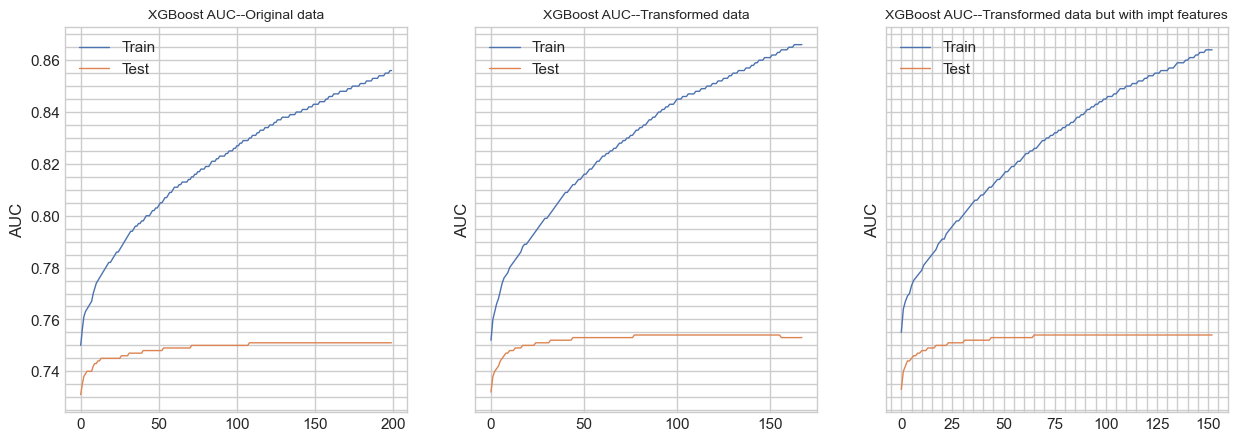

In [ ]:
# 12.0 Learning curves of all the three models

plt.style.use('seaborn-v0_8-whitegrid')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,3, figsize = (15,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(),model_trans_impt.evals_result() ]
title = ["XGBoost AUC--Original data", 'XGBoost AUC--Transformed data', 'XGBoost AUC--Transformed data but with impt features']

for i in range(3):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_title(title[i], fontsize = 10);

plt.show();



## Preparing for PCA--imputing data
PCAs of transformed data

In [ ]:
# 13.0 Check if any nulls in data
#       If so, we would impute using SimpleImputer:

X_train_trans.isnull().sum().sum()  # 0
X_test_trans.isnull().sum().sum()   # 61944
pca_train = X_train_trans.copy()
pca_test  = X_test_trans.copy()
_=gc.collect()

0

61944

In [ ]:
# 13.1 Impute as test data has null values:

start = time.time()
print("Imputing....")
si = SimpleImputer(strategy = 'median')
pca_train[:] = si.fit_transform(pca_train)
pca_test[:] = si.transform(pca_test)
end = time.time()
print("Done: ", (end-start)/60)  # 8 min

Imputing....
93.65597288211187


In [ ]:
# 13.1.1 Check for nulls again:

pca_train.isnull().sum().sum()  # 0
pca_test.isnull().sum().sum()   # 0

0

0

### Save imputed data

In [ ]:
# 13.2 Save pca_train and pca_test for later experiments:

pca_train.to_pickle(Path(avazufolder) / "pca_train_imputed.pkl")
pca_test.to_pickle(Path(avazufolder) / "pca_test_imputed.pkl")

# 13.2.0 Datashapes
pca_train.shape  # (1501119, 586)
pca_test.shape   # (500374, 586)

(1501119, 586)

(500374, 586)

### Read imputed data

In [ ]:
# 13.2.1 Read back saved pca_train and pca_test data:

pca_train = pd.read_pickle(Path(avazufolder) / "pca_train_imputed.pkl")
pca_test = pd.read_pickle(Path(avazufolder) / "pca_test_imputed.pkl")

# 13.2.2 Check
pca_train.shape  # (1501119, 586)
pca_test.shape   # (500374, 586)

(1501119, 586)

(500374, 586)

### Perform PCA

In [ ]:
# 13.3 PCA with transformed train data.
#      Note that n_components = 0.95


pca = PCA(n_components= 0.95, whiten= True, random_state = None)
ss = StandardScaler()
pca_train = pca.fit_transform(ss.fit_transform(pca_train))
pca_test = pca.transform(ss.transform(pca_test))

# 13.3.1 Check data shapes:
pca_train.shape  # (1501119, 97)
pca_test.shape   # (500374, 97)

(1501119, 97)

(500374, 97)

In [ ]:
# 13.4 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(pca_train.shape[1])]
pca_train = pd.DataFrame(pca_train, columns = colnames)
pca_test = pd.DataFrame(pca_test, columns = colnames)

# 13.4.1 Dataframe shapes:
pca_train.shape  # (1501119, 97)
pca_test.shape   # (500374, 97)

(1501119, 97)

(500374, 97)

### Plotting PCA

In [ ]:
# 13.5 Take a stratified sample for plotting:
#      Just 5000 samples:

_, pca_tr, _,pca_y  = train_test_split(pca_train, y_train,
                                       test_size = 5000,
                                       stratify = y_train
                                      )

# 13.5.1 Our data for plotting:
pca_tr.shape  # (5000, 97)
pca_y.shape   # (5000,)

(5000, 97)

(5000,)

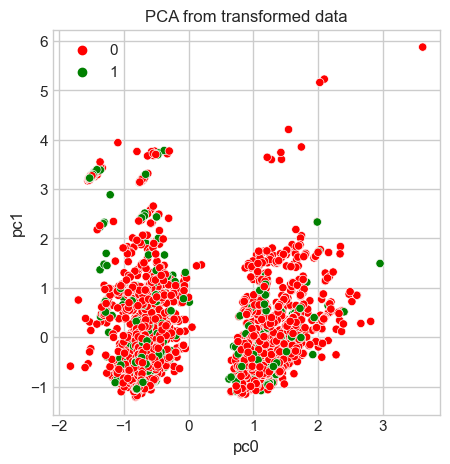

In [ ]:
# 13.6 2D PCA plot from first two principal components:

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ; # Set default theme
sns.scatterplot(data = pca_tr,
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed data') ;

### Save PCA data

In [ ]:
# 14.0 Save pca_train and pca_test for later experiments:

pca_train.to_pickle(Path(avazufolder) / "pca_train.pkl")
pca_test.to_pickle(Path(avazufolder) / "pca_test.pkl")

### Read back PCA data

In [ ]:
# 14.1 Read back saved data:

pca_train = pd.read_pickle(Path(avazufolder) / "pca_train.pkl")
pca_test =  pd.read_pickle(Path(avazufolder) / "pca_test.pkl")

# 14.1.1 Check
pca_train.head(3)
pca_test.head(3)

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc87,pc88,pc89,pc90,pc91,pc92,pc93,pc94,pc95,pc96
0,-0.110558,0.391667,0.947952,-0.752439,0.968413,-0.148203,0.865470,-0.976195,-0.723588,-0.442553,...,0.516419,2.582526,-0.553345,-2.463318,-2.077558,-0.657861,0.285738,1.240242,-0.058218,1.161464
1,-0.733898,-0.354613,0.169319,-1.333093,-0.645201,-0.304156,-0.054446,-0.113526,-0.327392,0.284426,...,0.199287,0.004526,0.945551,-0.094655,-0.886836,-0.054732,-0.245707,0.976586,-0.923580,-0.040574
2,-1.124315,2.983324,-1.866613,1.471045,-1.286400,0.637731,-0.228197,-1.181240,0.067103,-0.183781,...,0.919299,-0.407810,0.263904,2.471808,1.019613,2.022206,-0.530977,0.213816,0.934615,-1.173179


,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc87,pc88,pc89,pc90,pc91,pc92,pc93,pc94,pc95,pc96
0,-0.780108,-0.678224,-0.183568,0.540262,0.104231,-0.294963,-0.390092,0.018555,-0.248950,0.249976,...,0.363174,-0.649712,-0.347930,0.584106,0.314693,0.463401,-1.093987,0.622039,-1.198858,0.903958
1,1.642762,0.495704,1.647339,1.660392,0.466110,-0.596386,-0.651829,-1.718513,1.427740,0.793548,...,0.630246,-1.211739,-0.748954,0.888853,0.817331,0.783583,-1.161689,-0.989906,-0.938472,0.187912
2,-0.782834,-1.009932,-0.182584,-0.118359,-0.476964,-0.412095,-0.345496,-0.448092,-0.723227,0.899824,...,0.446000,0.143494,0.086705,-0.095599,-0.409480,-0.048833,-0.252410,-0.347925,-0.020998,0.181105


### xgboost modeling with all the PCA components

In [ ]:
# 15.0 Prepare xgboost model--PCA data

# 15.0.1 We use class weights also:
#        Actually there is no benefit:

class_weights = {0: 1, 1: 10}

model_pca = xgb.XGBClassifier( n_estimators= 200,
                           verbosity = 3,
                           eta = 0.06,
                           max_depth = 15,
                           subsample = 0.8,
                           class_weight = class_weights,
                           random_state = rng,
                           )


tr_X =   pca_train
test_X = pca_test
ytrain = y_train
ytest = y_test


model_pca.fit(tr_X, ytrain.values,
                     early_stopping_rounds = 50,   # 10% of n_estimators
                     eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
                     eval_metric = ['auc']    # binary classification problem
                    )

[12:58:30] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "class_weight" } are not used.

[12:58:30] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[12:58:36] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 8492 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.73264	validation_1-auc:0.70312
[12:58:41] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7852 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.74854	validation_1-auc:0.71475
[12:58:45] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7798 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.75491	validation_1-auc:0.71869
[12:58:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight={0: 1, 1: 10}, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False, eta=0.06,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# 15.1 Best Scores:

model_pca.best_score     # 0.737592962
model_pca.best_iteration # 62

0.7375929627977279

62

### Classification report
xgboost modeling with PCA data

In [ ]:
# 15.2 Classification report of model with PCA data:

pred = model_pca.predict(test_X)
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91    352805
           1       0.57      0.08      0.14     72357

    accuracy                           0.83    425162
   macro avg       0.71      0.53      0.52    425162
weighted avg       0.79      0.83      0.78    425162



### Learning curve
xgboost modeling with PCA data

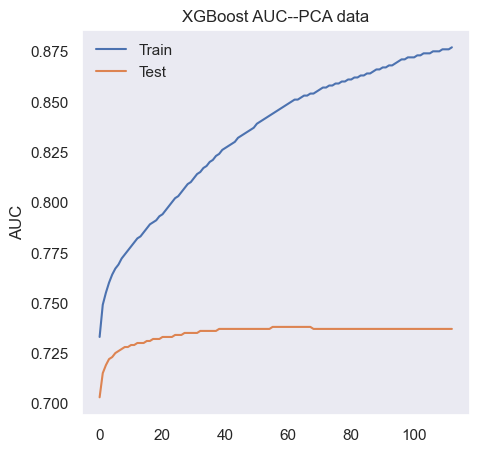

In [ ]:
# 15.3 Learning curve of xgboost based on pca data:
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,1, figsize = (5,5));

results = model_pca.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs);
ax.plot(x_axis, np.round(results['validation_0']['auc'],3), label='Train');
ax.plot(x_axis, np.round(results['validation_1']['auc'],3), label='Test');
ax.legend();
ax.grid();
ax.set_ylabel('AUC');
ax.set_title("XGBoost AUC--PCA data");

## Balanacing PCA train data with `imblearn` library
We use imblearn library
>Balance with [`EditedNearestNeighbours`](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html)<br>
>Balance with [`SMOTEENN`](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html)<br>

In [ ]:
# 16.0 Call imblearn library:

from imblearn.under_sampling import EditedNearestNeighbours   # This works with full PCA
from imblearn.combine import SMOTEENN

## Using `EditedNearestNeighbours`

In [ ]:
# 16.1 Undersample PCA train data:

start = time.time()
undersample = EditedNearestNeighbours()
X_res, y_res = undersample.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 29min

# 16.1.1 Data shape
X_res.shape  #  (1075328, 97)
y_res.shape  #  (1075328,)

29.241472180684408


(1075328, 97)

(1075328,)

### Plot of Ist two components of cleanedup data

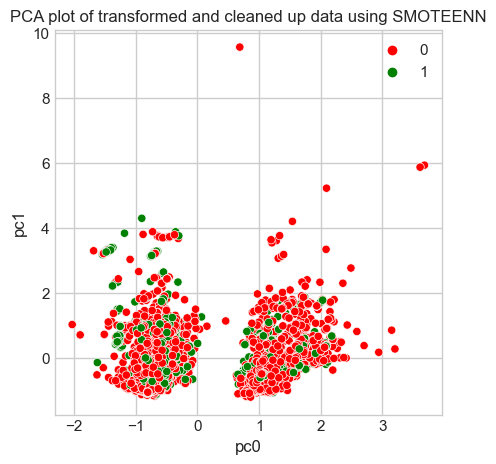

In [ ]:
# 17.0 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res, y_res, test_size = 5000, stratify = y_res)
pca_tr.shape  # (5000, 71)
pca_y.shape   # (5000,)

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ;
sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["red", "green"]
                ).set(title='PCA plot of transformed and cleaned up data using EditedNearestNeighbours') ;

### xgboost modeling with undersampled data

In [ ]:
# 17.3 xgboost Modeling with undersampled data

model_en = xgb.XGBClassifier( n_estimators= 500,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.9,
                               random_state = rng,
                           )


tr_X =   X_res
test_X = pca_test
ytrain = y_res
ytest =  y_test


model_en.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,
          eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']
          )



[06:29:32] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[06:29:38] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7502 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.81530	validation_1-auc:0.70857
[06:29:44] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7410 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.82904	validation_1-auc:0.71812
[06:29:50] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7144 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.83266	validation_1-auc:0.72051
[06:29:57] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 7712 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.83640	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 17.4 Scores:

model_en.best_score     # 0.738117
model_en.best_iteration # 78

0.7381170629170162

78

### Classification report
After balancing data with `EditedNearestNeighbours` class

In [ ]:
# 17.5 Classification report xgboost model with undersampled PCA data:

pred = model_en.predict(test_X)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87    415242
           1       0.36      0.39      0.38     85132

    accuracy                           0.78    500374
   macro avg       0.62      0.62      0.62    500374
weighted avg       0.79      0.78      0.78    500374



## Using `SMOTEENN`
For balancing PCA data

In [ ]:
# 18.0 Instantiate SMOTEEN and use it on pca_train

start= time.time()
sm = SMOTEENN(random_state=rng)
X_res, y_res = sm.fit_resample(pca_train, y_train)
end = time.time()
print((end-start)/60)  # 60 min(15L), 97min(20L)


# 18.0.1 Data shape after SMOTEENN

X_res.shape  # (1688427, 97)
y_res.shape  # (1688427,)

97.95929827690125


In [ ]:
# 18.0.2
y_res.value_counts()
y_res.value_counts(normalize = True)  # 57%:43%

1    971692
0    716735
Name: click, dtype: int64

1    0.575501
0    0.424499
Name: click, dtype: float64

### Plot of Ist two components of cleanedup data

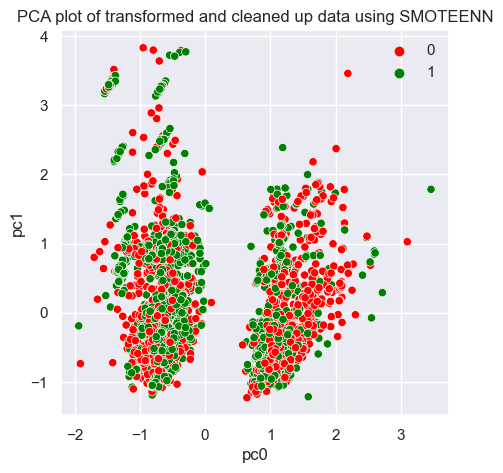

In [ ]:
# 18.0.3 2D PCA plot from first two principal components:
#         First take a stratified sample for plotting
#         And then plot:

_, pca_tr, _,pca_y  = train_test_split(X_res, y_res, test_size = 5000, stratify = y_res)
pca_tr.shape  # (5000, 71)
pca_y.shape   # (5000,)

fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.set_theme() ;
sns.scatterplot(data = pca_tr,  # Sample of 5000
                x=  'pc0',
                y = 'pc1',
                hue = pca_y.values,
                palette = ["red", "green"]
                ).set(title='PCA plot of transformed and cleaned up data using SMOTEENN') ;

### xgboost modeling with balanced data (SMOTEENN)

In [ ]:
# 19.0 Modeling with smoteenn data

model_sm = xgb.XGBClassifier( n_estimators= 500,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 15,
                               subsample = 0.8,
                               random_state = rng,
                           )


tr_X =   X_res
test_X = pca_test
ytrain = y_res
ytest =  y_test


model_sm.fit(tr_X, ytrain.values,
                early_stopping_rounds = 100,
                eval_set=[(tr_X, ytrain.values), (test_X, ytest.values)],
                eval_metric = ['auc']
                )



[04:45:40] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[04:45:51] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9866 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.86828	validation_1-auc:0.70811
[04:46:02] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9524 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.88033	validation_1-auc:0.71604
[04:46:13] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9586 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.88544	validation_1-auc:0.71916
[04:46:25] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 9818 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.88958	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 19.1 score
model_sm.best_score   # 0.7320805711
model_sm.best_iteration  # 33

0.7320805711660064

33

### Classification report
After balancing with `SMOTEENN` class

In [ ]:
# 19.2
pred = model_sm.predict(test_X)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.93      0.54      0.69    415242
           1       0.26      0.79      0.40     85132

    accuracy                           0.59    500374
   macro avg       0.60      0.67      0.54    500374
weighted avg       0.82      0.59      0.64    500374



### Learning plots
xgboost modeling with the two class balancing techniques

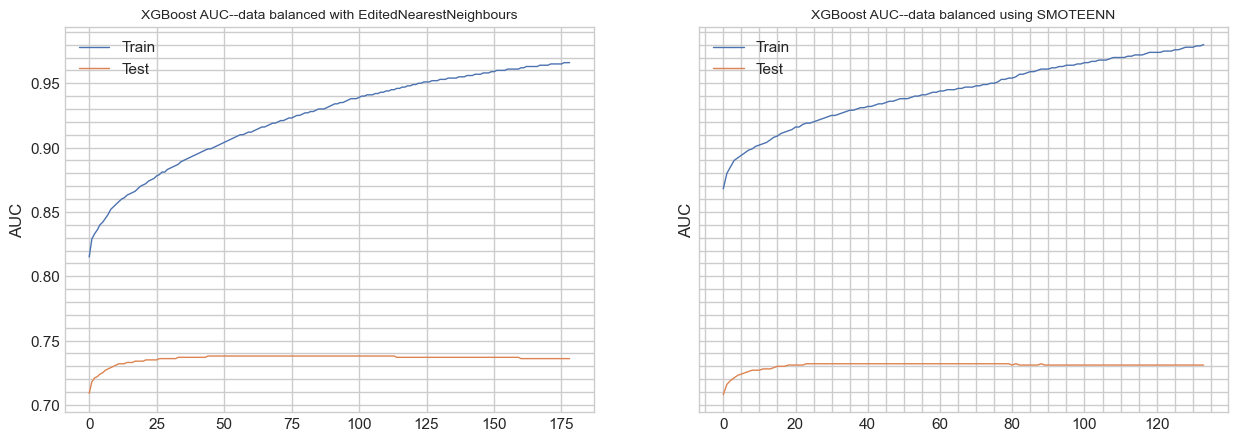

In [ ]:
# 19.3 Learning curves: xgboost modeling"

plt.style.use('seaborn-v0_8-whitegrid')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (15,5), sharey = True);
results = [model_en.evals_result(),model_sm.evals_result()]
title = ["XGBoost AUC--data balanced with EditedNearestNeighbours", 'XGBoost AUC--data balanced using SMOTEENN']

for i in range(2):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='Train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='Test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    plt.minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_title(title[i], fontsize = 10);

plt.show();

## Distribution of transformed features:

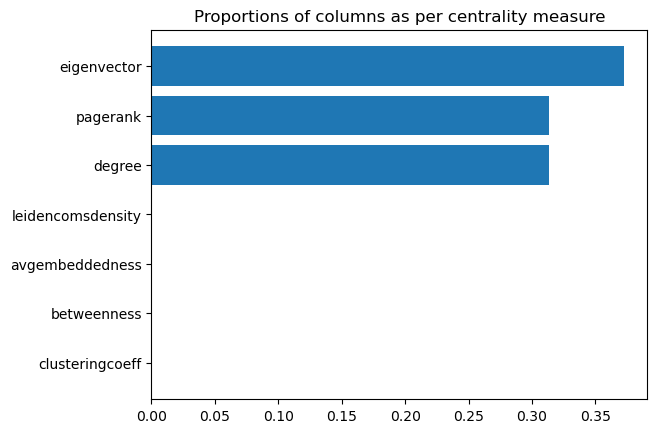

In [ ]:
# Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

# 20.0 Our list of columns

colList = X_train_trans.columns

# 20.0.1 Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
utils.plotSeries(f, "Proportions of columns as per centrality measure")


### Proportions of columns by centrality whose impt is > 0

In [ ]:
# 20.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"

Order of feature importance is by 'gain'


'Columns whose impt is >0: 414'

'Columns whose impt is 0: 172'

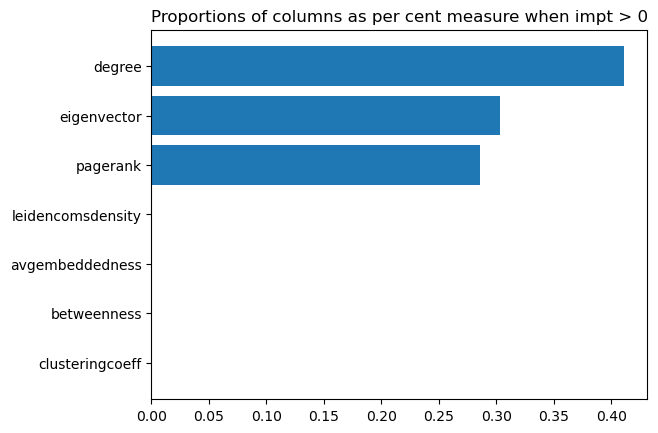

In [ ]:
# 20.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")



### Proportions of columns by summed-up importance score of each centrality measure

Order of feature importance is by 'gain'


eig_Cseventeen_ck_Ceighteen     0.222711
pr_Ctwentyone_ck_devicemodel    0.173471
pr_sitedomain_ck_Cfifteen       0.034185
pr_appdomain_ck_Csixteen        0.025518
deg_Cseventeen_ck_Csixteen      0.022762
Name: imp, dtype: float32

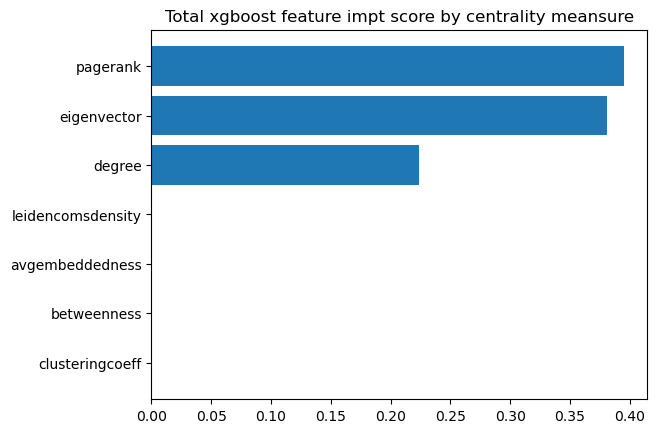

In [ ]:
# 20.3 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)

# 20.4 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 13.2 Score of top-five columns:
score[:5]

# 20.5 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Analysing Graphs


In [ ]:
# 21.0 Path where .gml files are placed:

pathToFolder = Path("D:\\avazu\\allmodels\\models\\")
filelist = sorted(list(pathToFolder.iterdir()))
filelist[5:10]   # mgrid_bigraph_*


[WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cfourteen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cnineteen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cone.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Cseventeen.gml'),
 WindowsPath('D:/avazu/allmodels/models/appcategory_bigraph_Csixteen.gml')]

### Readback data files

In [ ]:
# 21.1
avazufolder = 'D:\\avazu\\allmodels\\data\\'

In [ ]:
# 21.2 Readback all saved files

train_trans = pd.read_pickle(Path(avazufolder) / "train_trans.pkl")
test_trans = pd.read_pickle(Path(avazufolder) / "test_trans.pkl")
X_train = pd.read_pickle(Path(avazufolder) / "X_train.pkl")
X_test = pd.read_pickle(Path(avazufolder) / "X_test.pkl")
y_train = pd.read_pickle(Path(avazufolder) / "y_train.pkl")
y_test = pd.read_pickle(Path(avazufolder) / "y_test.pkl")


# 21.2.1 Reindex X_train/X_test

X_train = X_train.reset_index( drop = True )
X_test = X_test.reset_index(drop = True)

# 21.2.2 Check
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

# 21.2.3
train_trans.shape   # (1501119, 599)
y_train.shape       # (1501119,)
test_trans.shape    # (500374, 599)
y_test.shape        # (500374,)

# 21.2.4 Our cat cols
cat_cols = ['Cone', 'bannerpos', 'siteid', 'sitedomain', 'sitecategory',
            'appid', 'appdomain', 'appcategory', 'devicemodel', 'devicetype',
            'deviceconntype', 'Cfourteen', 'Cfifteen','Csixteen', 'Cseventeen',
            'Ceighteen', 'Cnineteen', 'Ctwenty', 'Ctwentyone']  # 19 cols

# 21.2.5 Remaining cols not treated as cat cols:

rem_cols = ['day', 'dayofweek', 'device_id',
            'device_ip', 'hour_time', 'month']  # 6 cols


# 21.3 Concat rem_cols with transformed data:

# 21.4 Columns after transformeation to be considered. Ignore initial cat_cols
cols = train_trans.columns[len(cat_cols):]

# 21.5 Now horizontally concatenate:
X_train_trans = pd.concat([X_train[rem_cols], train_trans[cols] ],  axis = 1)
X_test_trans = pd.concat([X_test[rem_cols], test_trans[cols] ], axis = 1)

# 21.6 Check
X_train_trans.shape  # (1501119, 586)
X_test_trans.shape   # (500374, 586)

,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1002,0,2148,2742,5,3650,104,0,2662,0,...,-0.153559,0.898305,0.156404,0.022265,0.525424,0.177803,0.023575,0.983051,0.145117,0.020541
1,1005,0,375,3371,1,3650,104,0,2695,1,...,-0.153559,0.898305,0.156404,0.022265,0.525424,0.177803,0.023575,0.983051,0.145117,0.020541


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,devicemodel,devicetype,...,eig_Ctwentyone_ck_Cseventeen,deg_Ctwentyone_ck_Ceighteen,eig_Ctwentyone_ck_Ceighteen,pr_Ctwentyone_ck_Ceighteen,deg_Ctwentyone_ck_Cnineteen,eig_Ctwentyone_ck_Cnineteen,pr_Ctwentyone_ck_Cnineteen,deg_Ctwentyone_ck_Ctwenty,eig_Ctwentyone_ck_Ctwenty,pr_Ctwentyone_ck_Ctwenty
0,1005,0,375,3371,1,3650,104,0,1208,1,...,0.205169,0.881356,0.159990,0.021333,0.728814,0.202321,0.034911,1.000000,0.145731,0.020989
1,1005,0,1617,2742,5,2280,148,4,115,1,...,0.017968,1.000000,0.165342,0.024729,0.796610,0.206627,0.037413,0.847458,0.136723,0.017584


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,device_id,device_ip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1002,0,2148,2742,5,3650,104,0,161766,77617,...,50,2684,2,1327,100062,52,10,2,29,16
1,1005,0,375,3371,1,3650,104,0,184577,649062,...,50,2299,2,1327,-1,52,10,3,30,14


,Cone,bannerpos,siteid,sitedomain,sitecategory,appid,appdomain,appcategory,device_id,device_ip,...,Csixteen,Cseventeen,Ceighteen,Cnineteen,Ctwenty,Ctwentyone,month,dayofweek,day,hour_time
0,1005,0,375,3371,1,3650,104,0,184577,16988,...,36,2524,0,35,-1,221,10,2,22,19
1,1005,0,1617,2742,5,2280,148,4,184577,58653,...,50,2424,1,161,100193,71,10,4,24,16


(1501119, 599)

(1501119,)

(500374, 599)

(500374,)

(1501119, 586)

(500374, 586)

In [ ]:
# 22.0 Get sample list of projected and bigraphs:

projected = [str(i).split("\\")[-1] for i in filelist if 'appcategory_projected' in str(i)]
bigraphs = [str(i).split("\\")[-1] for i in filelist if 'appcategory_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:8]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:8]    # projected graph files

['appcategory_bigraph_Cone.gml',
 'appcategory_bigraph_appid.gml',
 'appcategory_bigraph_siteid.gml',
 'appcategory_bigraph_Ctwenty.gml',
 'appcategory_bigraph_Cfifteen.gml',
 'appcategory_bigraph_Csixteen.gml',
 'appcategory_bigraph_appdomain.gml',
 'appcategory_bigraph_bannerpos.gml']



====



['appcategory_projected_Cone.gml',
 'appcategory_projected_appid.gml',
 'appcategory_projected_siteid.gml',
 'appcategory_projected_Ctwenty.gml',
 'appcategory_projected_Cfifteen.gml',
 'appcategory_projected_Csixteen.gml',
 'appcategory_projected_appdomain.gml',
 'appcategory_projected_bannerpos.gml']

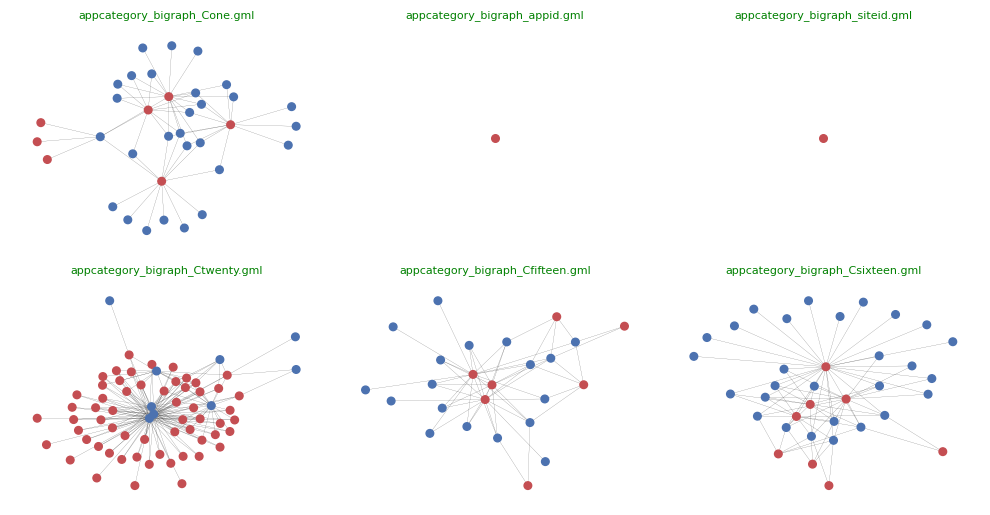

In [ ]:
# 22.1 Plot of sample bigraphs:
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:6]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _= utils.plotBipartiteGraph( bi,
                                 pathToFolder,
                                 ax = ax,
                                 title = bi,
                                 connected=True,  # Show only connected nodes
                                 takeGraphSample=True # Do not show full graph but a sample of it
                                 )
    plt.tight_layout();

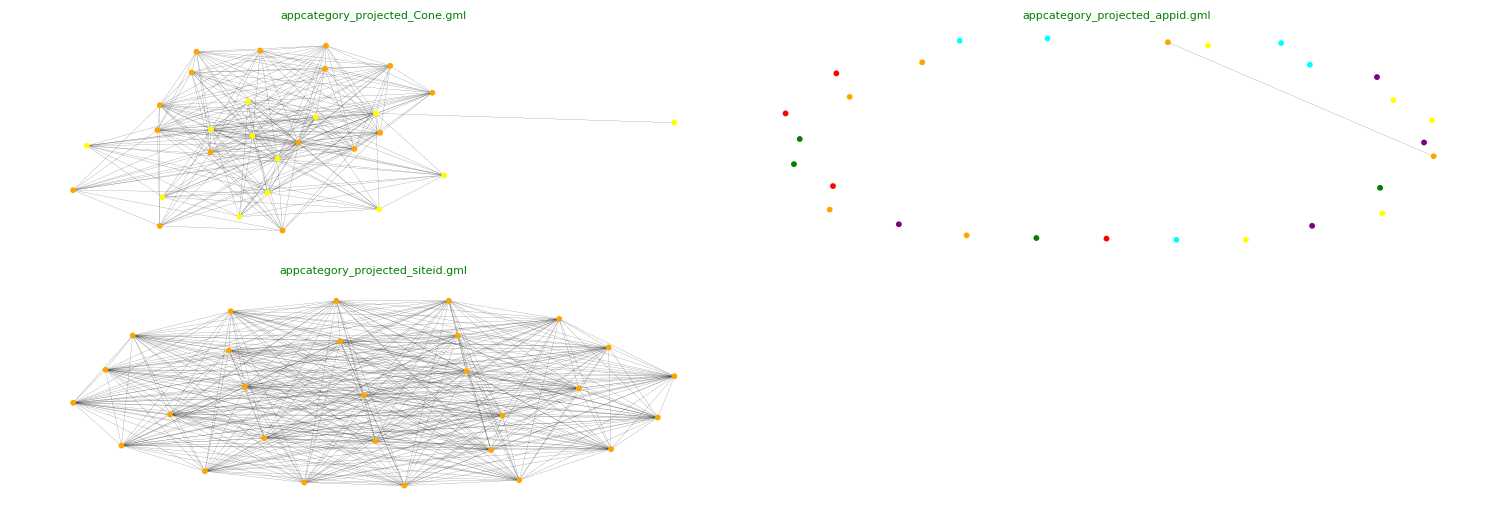

In [ ]:
# 22.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:3]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   pathToFolder,
                                   ax = ax,
                                   k = 1.5,   # For spring_layout, to avoid crowding of nodes
                                   withLabels = False,
                                   node_size = 10,
                                   title = prj,
                                   takeGraphSample = True # Do not show full graph but a sample of it
                                   );
    plt.tight_layout();

In [ ]:
# 23.0 Transform each column bin as per the community
#       to which it belongs:

# 23.1 Our transformed discrete cols are:
columnNames = cat_cols

# 23.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 23.3 Graph files are within:
pathToGraphFolder= Path("D:\\avazu\\allmodels\\models\\")

# 23.4 Perform transformation of both train_binned and test_binend:
# 23.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []
map_tr = []
map_te = []

# 23.4.2 PErform transformation to community structure
#  Takes lots of time...

for algo in algolist:
  print("\n..Transforming train data....")
  print("==========================\n")
  map1,df_tr = utils.transformBinnedDF2Communities(columnNames,pathToGraphFolder,X_train[cat_cols], algo = algo)
  print("\n==========================")
  print("..Transforming test data....")
  print("==========================\n")
  map2,df_te = utils.transformBinnedDF2Communities(columnNames,pathToGraphFolder,X_test[cat_cols], algo = algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)
  map_tr.append(map1)
  map_te.append(map2)


..Transforming train data....

Reading file:  siteid_projected_Cone.gml
Reading file:  siteid_projected_bannerpos.gml
Reading file:  siteid_projected_sitedomain.gml
Reading file:  siteid_projected_sitecategory.gml
Reading file:  siteid_projected_appid.gml
Reading file:  siteid_projected_appdomain.gml
Reading file:  siteid_projected_appcategory.gml
Reading file:  siteid_projected_devicemodel.gml
Reading file:  siteid_projected_devicetype.gml
Reading file:  siteid_projected_deviceconntype.gml
Reading file:  siteid_projected_Cfourteen.gml
Reading file:  siteid_projected_Cfifteen.gml
Reading file:  siteid_projected_Csixteen.gml
Reading file:  siteid_projected_Cseventeen.gml
Reading file:  siteid_projected_Ceighteen.gml
Reading file:  siteid_projected_Cnineteen.gml
Reading file:  siteid_projected_Ctwenty.gml
Reading file:  siteid_projected_Ctwentyone.gml
Reading file:  sitedomain_projected_Cone.gml
Reading file:  sitedomain_projected_bannerpos.gml
Reading file:  sitedomain_projected_siteid

In [ ]:
# 24.0 Observe few rows of data transformed community wise:
fg_tr[0].shape   # (1501119, 212)
print("\n--\n")
fg_te[0].shape   # (500374, 212)
print("\n--\n")
fg_tr[0].head(2)
fg_te[0].head(2)

(1501119, 212)


--



(500374, 212)


--



,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_appdomain.gml,siteid_projected_appcategory.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,...,Ctwentyone_projected_appdomain.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_deviceconntype.gml,Ctwentyone_projected_Cfifteen.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,1,1,1
1,1,0,858,4,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,1,1


,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_appdomain.gml,siteid_projected_appcategory.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,...,Ctwentyone_projected_appdomain.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_devicetype.gml,Ctwentyone_projected_deviceconntype.gml,Ctwentyone_projected_Cfifteen.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,1.0,0.0,858.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,0,1
1,2.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0,0,1,0,0,0,1,1,0,0


In [ ]:
# 24.1 Remove constant columns from train data:
fg_tr[0] = utils.remConstColumns(fg_tr[0])

# 24.1.1 Keep same columns as above in test data:
fg_te[0] = fg_te[0][fg_tr[0].columns]

Datashape before processing: (1501119, 212)
Datashape after processing: (1501119, 161)


In [ ]:
# 24.2 Save the list to gdrive:

utils.savePythonObject(fg_tr, "fg_tr.pkl", avazufolder)
utils.savePythonObject(fg_te, "fg_te.pkl", avazufolder)

Object saved to: D:\avazu\allmodels\data\fg_tr.pkl
Object saved to: D:\avazu\allmodels\data\fg_te.pkl


In [ ]:
# 24.3

tr_comm = utils.restorePythonObject( "fg_tr.pkl", avazufolder )
te_comm = utils.restorePythonObject( "fg_te.pkl", avazufolder )
tr_comm[0].shape  # (1501119, 161)
te_comm[0].shape  # (500374, 161)

(1501119, 161)

(500374, 161)

In [ ]:
# 24.4 Check restoration:

tr_comm[0].head(2)
te_comm[0].head(2)

,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,siteid_projected_Cfourteen.gml,siteid_projected_Cfifteen.gml,...,Ctwenty_projected_Ctwentyone.gml,Ctwentyone_projected_Cone.gml,Ctwentyone_projected_siteid.gml,Ctwentyone_projected_appid.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,0,0,1,0,0,1,1,0,1,1,...,0,0,0,0,0,0,1,1,1,1
1,1,0,858,4,0,0,0,1,1,0,...,0,0,0,0,0,0,1,1,1,1


,siteid_projected_Cone.gml,siteid_projected_bannerpos.gml,siteid_projected_sitedomain.gml,siteid_projected_sitecategory.gml,siteid_projected_appid.gml,siteid_projected_devicemodel.gml,siteid_projected_devicetype.gml,siteid_projected_deviceconntype.gml,siteid_projected_Cfourteen.gml,siteid_projected_Cfifteen.gml,...,Ctwenty_projected_Ctwentyone.gml,Ctwentyone_projected_Cone.gml,Ctwentyone_projected_siteid.gml,Ctwentyone_projected_appid.gml,Ctwentyone_projected_appcategory.gml,Ctwentyone_projected_devicemodel.gml,Ctwentyone_projected_Csixteen.gml,Ctwentyone_projected_Ceighteen.gml,Ctwentyone_projected_Cnineteen.gml,Ctwentyone_projected_Ctwenty.gml
0,1.0,0.0,858.0,4.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,1
1,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1,0,0,0,0,1,1,1,0,0


## xgboost modeling with data transformed through community classes

In [ ]:
# 25.0 Modeling with transformed train/test data with community indicators:

# As we repeat the process many times:
# Del the earlier result, if exists:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 500,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = rng,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = y_train
yte = y_test


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 100,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[12:38:04] DEBUG: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\gbm\gbtree.cc:157: Using tree method: 2
[12:38:08] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5024 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.73836	validation_1-auc:0.73074
[12:38:11] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4712 extra nodes, 0 pruned nodes, max_depth=14
[1]	validation_0-auc:0.74180	validation_1-auc:0.73332
[12:38:14] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 5016 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.74372	validation_1-auc:0.73483
[12:38:16] INFO: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\tree\updater_prune.cc:98: tree pruning end, 4956 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.74522	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

### Learning curve

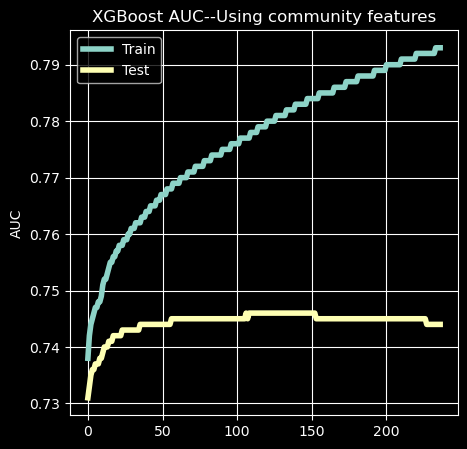

In [ ]:
# 25.1 Modeling with Community data:

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_trans_commu.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=4, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=4, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Using community features");


#### Classification report

In [ ]:
# 25.2 Classification reports:

pred_comm = model_trans_commu.predict(test_X)
print(f"Classification report from community data: \n {classification_report(ytest,pred_comm)}")


Classification report from community data: 
               precision    recall  f1-score   support

           0       0.84      0.99      0.91    415242
           1       0.60      0.08      0.15     85132

    accuracy                           0.83    500374
   macro avg       0.72      0.54      0.53    500374
weighted avg       0.80      0.83      0.78    500374



## PCA of transformed community indicators

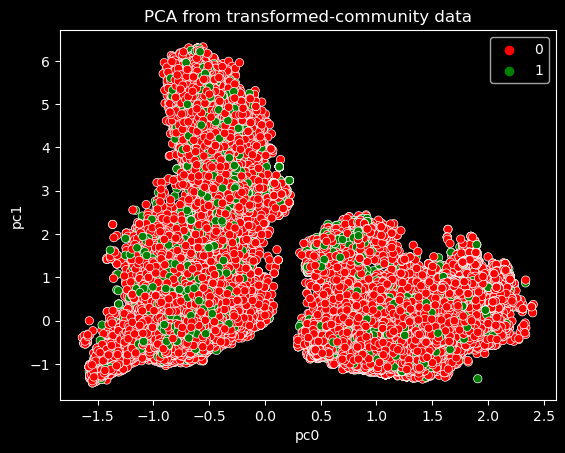

In [ ]:
# 25.3 Impute train data:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy = "most_frequent")
fg_tr[0][:] = si.fit_transform(fg_tr[0])
fg_tr[0].head(3)

# 25.4 PCA next:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
commu_pca = pca.fit_transform(ss.fit_transform(fg_tr[0]))

# 25.5 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(commu_pca.shape[1])]
commu_pca = pd.DataFrame(commu_pca, columns = colnames)

# 25.6 PCA plot of transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = commu_pca,
                x=  commu_pca.pc0,
                y = commu_pca.pc1,
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed-community data') ;

In [ ]:
############# Done ###############